# Random Boolean Networks

## Galen Wilkerson


## This notebook builds and runs basic Random Boolean Networks

Kauffman, Stuart. "Homeostasis and differentiation in random genetic control networks." Nature 224.5215 (1969): 177-178.

More here:
https://en.wikipedia.org/wiki/Boolean_network

Basically, a Random Boolean Network is a directed network where each of the $N$ nodes has $k$ random neigbors.

In [15]:
import numpy as np
import itertools as it
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Possible Boolean Functions on m rows

In [16]:
N = 10 # number of nodes
k = 3  # number of inputs per node

m = 2**k  # number of rows
num_functions = 2**m
num_functions

256

## inputs of truth table

In [17]:
truth_inputs = np.array(list(it.product([0,1], repeat=k)))
truth_inputs

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

## possible outputs of each row

In [18]:
# each row is the output of a truth table
#m = 5
combs = list(it.product([0,1], repeat=m))
possible_output_functions = np.array(combs)
possible_output_functions.shape

(256, 8)

In [19]:
class RBN:
    '''
    '''
    
    def __init__(self, N, k):#, num_iterations = 10):
        '''
        create the network, 
        assign Boolean functions to each node, 
        and initalize the node states
        '''
        
        self.G = nx.DiGraph()
        self.G.add_nodes_from(range(N))

#         for i in range(N):
#             while self.G.in_degree(i) < k:
#                 new_neighbor = np.random.randint(N)
#                 if (new_neighbor != i):
#                     self.G.add_edge(new_neighbor, i)
                    
#         node_list = list(range(N))

#         # add k edges per node
#         for i in node_list:
#             node_list_without_i = node_list
#             node_list_without_i.remove(i)
#             neighbors = np.random.choice(node_list_without_i, k, replace=False)
#             for j in neighbors:
#                 self.G.add_edge(j,i)
            

        node_list = list(range(N))

        # add k edges per node
        for i in node_list:
            while self.G.in_degree(i) < k:
                node_list_without_i = node_list.copy()
                node_list_without_i.remove(i)
                # remove existing in-neighbors
                for j in list(self.G.predecessors(i)):
                    node_list_without_i.remove(j)

                neighbors = np.random.choice(node_list_without_i, k, replace=False)
                for neighbor in neighbors:
                    self.G.add_edge(neighbor,i)
            
            
            
            
        self.m = 2**k  # number of rows
        self.num_functions = 2**self.m
        
        # global list of truth table inputs
        self.truth_inputs = np.array(list(it.product([0,1], repeat=k)))   
               
        # each row is the output of a truth table
        combs = list(it.product([0,1], repeat=self.m))
        self.possible_output_functions = np.array(combs)
        
        # assign Boolean function to each node
        self.node_functions = self.possible_output_functions[np.random.randint(self.num_functions, size=N)]
        
        # the initial node states
        self.node_states = np.random.randint(2, size = N)
    
        self.pos = {} # for storing node positions when drawing
    
    def draw(self, fig_size = [5,5]):
        '''
        draw the network
        '''
#         pos = nx.circular_layout(self.G)
        #nx.draw(self.G, pos = None, with_labels=True, node_color='lightblue')
    
    
        on_nodes = list(np.where(self.node_states == 1)[0])
        off_nodes = list(np.where(self.node_states == 0)[0])

        plt.figure(figsize=fig_size)
        plt.title('RBN with node states')
        plt.box(on=None)
        if self.pos == {}:
            self.pos = nx.spring_layout(self.G)
        
        nx.draw_networkx_nodes(self.G, pos=self.pos, nodelist=on_nodes,
                               node_color='lightgreen', label='on nodes');
        nx.draw_networkx_nodes(self.G, pos=self.pos, nodelist=off_nodes, edgecolors='grey',
                               node_color='lightblue', label='off nodes');
        nx.draw_networkx_labels(self.G, self.pos, font_color = 'red', font_weight = 'bold')
        nx.draw_networkx_edges(self.G, pos=self.pos, edge_color='lightgrey')
        plt.legend(scatterpoints = 1)
        plt.show()
    
    
    def binary_to_int(self, input_vals):
        '''
        take any list or 1-dim array of binary values and convert to integer
        '''
        string_list = np.array(input_vals).astype(str)
        concated_string = ''.join(string_list)
        integer_val = int(concated_string, 2)
        return(integer_val)
    
    
    def run(self, num_iterations = 100):
        '''
        run the RBN
        '''
        
        self.num_iterations = num_iterations
        
        states = []
        
        for it in range(self.num_iterations):
#             print(self.node_states)
            states.append(self.binary_to_int(self.node_states))
            next_states = np.zeros(self.G.number_of_nodes(), dtype=int)
        
            for i in range(self.G.number_of_nodes()):
                neighbor_states = []

                in_neighbors = list(self.G.predecessors(i))
    #             print(in_neighbors)
    
                # get the states of all i's incoming neighbors
                for j in range(len(in_neighbors)):

                    neighbor_states.append(self.node_states[in_neighbors[j]])
#                 neighbor_states_int = (int(''.join(np.array(neighbor_states).astype(str)),2))
                try:
                    neighbor_states_int = self.binary_to_int(neighbor_states)
                except:
                    continue
                    #print(neighbor_states)
                function_value = self.node_functions[i][neighbor_states_int]
                next_states[i] = function_value

            if np.array_equal(self.node_states,next_states):
                exit()
            else:
                self.node_states = next_states
                
        # since states are binary and listed in order of nodes, we can convert to unique integers
        states.append(self.binary_to_int(self.node_states))
        self.run_states = np.array(states)
   
        self.state_graph = nx.DiGraph()
        self.state_graph.add_nodes_from(set(self.run_states))

        for i in range(len(self.run_states)-1):
            j = i + 1
            self.state_graph.add_edge(self.run_states[i],self.run_states[j])

    def draw_state_graph(self):
#         pos = nx.circular_layout(selfstate_graph)
#         nx.draw(self.state_graph, node_color='lightblue', with_labels=True)

        plt.figure()
        plt.title('state graph colored by Eigen-centrality')
        try:
            eigvec_centrality = nx.eigenvector_centrality_numpy(self.state_graph)
            nx.draw(self.state_graph, with_labels = True,
                node_color = np.round(list(eigvec_centrality.values()), 2), 
                cmap = plt.cm.get_cmap('Greys'))
            
        except:
            nx.draw(self.state_graph, with_labels = True,
                    cmap = plt.cm.get_cmap('Greys'))
#         plt.legend(scatterpoints = 1)
    
        plt.show();
    
    
    def list_state_loops(self):
        return(list(nx.cycles.simple_cycles(self.state_graph)))
        
    def draw_state_graph_heatmap(self):
        adj = nx.adjacency_matrix(self.state_graph).todense()
        sns.heatmap(adj, xticklabels=list(self.state_graph.nodes), yticklabels=list(self.state_graph.nodes));

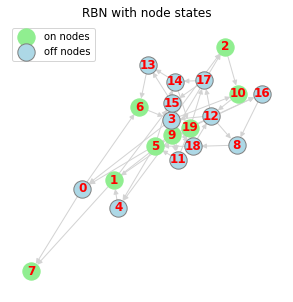

In [20]:
rbn = RBN(N = 20, k = 2)
rbn.draw()

## run one step

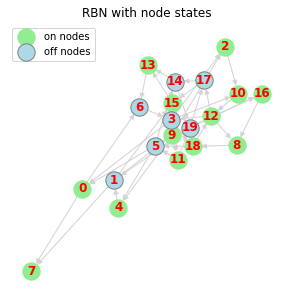

In [21]:
rbn.run(num_iterations=1)
rbn.draw()

In [22]:
rbn.node_states

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0])

## At any given time, the network state is just the on/off pattern of the nodes

## Let's show the states it explores when run many times

## since states are binary and listed in order of nodes, we can convert to unique integers


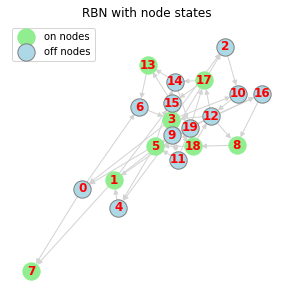

In [23]:
rbn.run(num_iterations=100)
rbn.draw()

In [24]:
rbn.node_states

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

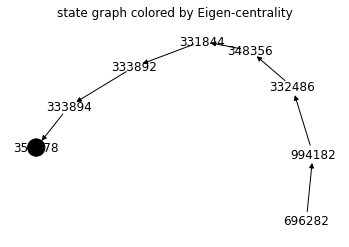

In [25]:
rbn.draw_state_graph()

## We can list the simple cycles in the state graph

In [26]:
rbn.list_state_loops()

[[350278]]

## Which states are most central?

## Let's round the centrality to undertand them better

(this might not always work)

In [27]:
eigvec_centrality = nx.eigenvector_centrality_numpy(rbn.state_graph)

eigenvals = np.array(list(eigvec_centrality.values()))

np.round(eigenvals,3)

array([0., 0., 0., 0., 0., 0., 1., 0.])

In [28]:
list(eigvec_centrality.keys())

[348356, 331844, 332486, 994182, 333892, 333894, 350278, 696282]